In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredLogarithmicError as msle
from sklearn.metrics import accuracy_score


In [2]:
data_path="http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"
data=pd.read_csv(data_path,header=None)


In [3]:
data.head()


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [6]:
features=data.drop(140,axis=1)
target=data[140]


In [7]:
x_train, x_test, y_train, y_test=train_test_split(features, target, test_size=0.2,stratify=target)


In [12]:
# we are setting 1 as it denotes normal sample and 0 denotes anomaly

train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]


In [13]:
# scaliing features in the range of 0 to 1
# x_train=x_train.astype("float32")/255
scaler=MinMaxScaler(feature_range=(0,1))
x_train_scaled=scaler.fit_transform(train_data.copy())
x_test_scaled = scaler.transform(x_test.copy())

In [18]:
class AutoEncoder(Model):
    def __init__(self,output_unit,code_size=8):
        super().__init__()
        # encoder
        self.encoder=Sequential([
            Dense(64,activation="relu"),
            Dropout(0.1),
            Dense(32,activation="relu"),
            Dropout(0.1),
            Dense(16,activation="relu"),
            Dropout(0.1),
            Dense(code_size,activation="relu")
        ])
        # decoder
        self.decoder=Sequential([
            Dense(16,activation="relu"),
            Dropout(0.1),
            Dense(32,activation="relu"),
            Dropout(0.1),
            Dense(64,activation="relu"),
            Dropout(0.1),
            Dense(output_unit,activation="sigmoid")
        ])
    def call(self,inputs):
        encoded=self.encoder(inputs)
        decoded=self.decoder(encoded)
        return decoded

In [19]:
y_train_scaled=y_train[y_train == 1]


In [20]:
model=AutoEncoder(output_unit=x_train_scaled.shape[1])
model.compile(optimizer="adam",loss="msle",metrics=["mse"])
History=model.fit(x_train_scaled,x_train_scaled,validation_data=(x_test_scaled, x_test_scaled),epochs=20,batch_size=512)

Epoch 1/20
5/5 [==============================] - 1s 63ms/step - loss: 0.0109 - mse: 0.0245 - val_loss: 0.0132 - val_mse: 0.0306
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0107 - mse: 0.0239 - val_loss: 0.0130 - val_mse: 0.0301
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0101 - mse: 0.0226 - val_loss: 0.0127 - val_mse: 0.0293
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0091 - mse: 0.0203 - val_loss: 0.0127 - val_mse: 0.0295
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0081 - mse: 0.0183 - val_loss: 0.0122 - val_mse: 0.0282
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0072 - mse: 0.0162 - val_loss: 0.0117 - val_mse: 0.0272
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0064 - mse: 0.0144 - val_loss: 0.0115 - val_mse: 0.0267
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0059 - mse: 0.0131 - val

Text(0.5, 0, 'epochs')

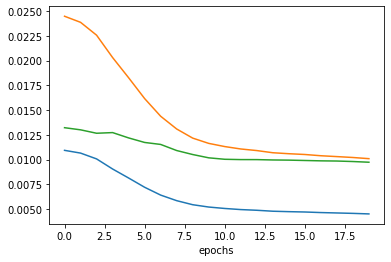

In [23]:
plt.plot(History.history['loss'],label='loss')
plt.plot(History.history['mse'],label='mse')
plt.plot(History.history['val_loss'],label='val_loss')
plt.xlabel("epochs")
